In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
import csv
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

In [2]:
# Set random seed for TensorFlow
tf.random.set_seed(123)

# Set random seed for Python
np.random.seed(123)


In [3]:
tf.keras.utils.set_random_seed(1)

tf.config.experimental.enable_op_determinism()

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:

data_all_county = pd.read_csv('/content/drive/My Drive/time_series/CA_data_lat_log_weekly.csv')


In [6]:
data_all_county['date'] = pd.to_datetime(data_all_county['date'])
data_all_county['month'] = data_all_county['date'].dt.month

Define helper functions

In [ ]:
def ts_multi_data_prep(dataset, target, start, end, window, step_out):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - step_out
        #end = len(dataset)
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i, i+step_out) #revise the window definition
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mse = metrics.mean_squared_error(y_true.flatten(), y_pred.flatten())
    mae = metrics.mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse = np.sqrt(mse)
    #mape = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten())
    r2 = metrics.r2_score(y_true.flatten(), y_pred.flatten())
    #print(f'MSE is : {mse}')
    #print(f'MAE is : {mae}')
    #print(f'RMSE is : {rmse}')
    #print(f'MAPE is : {mape}')
    #print(f'R2 is : {r2}\n')
    return mse, mae

In [ ]:
def timeseries_evaluation_metrics_binary(y_true, y_pred):

    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    precision = precision_score(y_true.flatten(), y_pred.flatten(), average='macro')
    recall = recall_score(y_true.flatten(), y_pred.flatten(), average='macro')
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='macro')

    #print(f'Accuracy: {accuracy}')
    #print(f'Precision: {precision}')
    #print(f'Recall: {recall}')
    #print(f'F1-score: {f1}\n')
    return f1

In [ ]:
def single_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    #print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def transform_county_data(x_data_array, y_data_array):
    # Lists to store x_train_c and y_train_c arrays
    x_c_list = []
    y_c_list = []
    # Divide the arrays into 'unique_fips_count' number of subarrays
    x_subarrays = np.array_split(x_data_array, unique_fips_count, axis=0)
    y_subarrays = np.array_split(y_data_array, unique_fips_count, axis=0)

    # Combine x_subarrays and y_subarrays into tuples
    data_tuples = [(x_subarray, y_subarray) for x_subarray, y_subarray in zip(x_subarrays, y_subarrays)]

    # Print or use the data tuples as needed
    for idx, data_tuple in enumerate(data_tuples):
        x_window_c, y_window_c = ts_multi_data_prep(data_tuple[0],data_tuple[1], 0, None, hist_window, step_out)
        # Append x_window_c and y_window_c arrays to lists
        x_c_list.append(x_window_c)
        y_c_list.append(y_window_c)

    # Stack arrays in lists to create x_train_c and y_train_c
    x_all_county = np.vstack(x_c_list)
    y_all_county = np.vstack(y_c_list)

    return x_all_county, y_all_county

In [ ]:

x_train_c, y_train_c, x_vali_c, y_vali_c, x_test_c, y_test_c = [], [], [], [], [], []
unique_fips = data_all_county['fips'].unique()
unique_fips_count = data_all_county['fips'].nunique()
for fips in unique_fips:
    # Extract dataframe for the current FIPS value
    data_county = data_all_county[data_all_county['fips'] == fips]

    X_data = data_county[['lat','lon','PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score','month']]
    Y_data = data_county[['score']]
    #train_val_test split 70%-10%-20%
    n = len(X_data)

    x_train_county = X_data[0:int(n*0.7)]
    y_train_county = Y_data[0:int(n*0.7)]
    x_vali_county = X_data[int(n*0.7):int(n*0.8)]
    y_vali_county = Y_data[int(n*0.7):int(n*0.8)]
    x_test_county = X_data[int(n*0.8):]
    y_test_county = Y_data[int(n*0.8):]


    if fips == 6001:
        x_train_c, y_train_c, x_vali_c, y_vali_c, x_test_c, y_test_c = x_train_county, y_train_county, x_vali_county, y_vali_county, x_test_county, y_test_county

    else:
        x_train_c = np.concatenate((x_train_c, x_train_county), axis=0)
        y_train_c = np.concatenate((y_train_c, y_train_county), axis=0)
        x_vali_c = np.concatenate((x_vali_c, x_vali_county), axis=0)
        y_vali_c = np.concatenate((y_vali_c, y_vali_county), axis=0)
        x_test_c = np.concatenate((x_test_c, x_test_county), axis=0)
        y_test_c = np.concatenate((y_test_c, y_test_county), axis=0)


In [ ]:
X_scaler_train = MinMaxScaler()
Y_scaler_train = MinMaxScaler()
X_scaler_test = MinMaxScaler()
Y_scaler_test = MinMaxScaler()
X_scaler_vali = MinMaxScaler()
Y_scaler_vali = MinMaxScaler()
x_train_data = X_scaler_train.fit_transform(x_train_c)
y_train_data = Y_scaler_train.fit_transform(y_train_c)
x_vali_data = X_scaler_vali.fit_transform(x_vali_c)
y_vali_data = Y_scaler_vali.fit_transform(y_vali_c)
x_test_data = X_scaler_test.fit_transform(x_test_c)
y_test_data = Y_scaler_test.fit_transform(y_test_c)

In [ ]:
def modeling1(hist_window, step_out, unit1, unit2, drop1, drop2, flag_report):

  x_train, y_train = transform_county_data(x_train_data, y_train_data)
  x_vali, y_vali = transform_county_data(x_vali_data, y_vali_data)
  x_test, y_test = transform_county_data(x_test_data, y_test_data)
  batch_size = 128
  buffer_size = 256

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential()
  lstm_model.add(tf.keras.layers.LSTM(unit1,input_shape=x_train.shape[-2:],return_sequences=True))
  lstm_model.add(tf.keras.layers.Dropout(drop1)),
  lstm_model.add(tf.keras.layers.LSTM(units=unit2,return_sequences=False)),
  lstm_model.add(tf.keras.layers.Dropout(drop2)),
  lstm_model.add(tf.keras.layers.Dense(units=step_out)),
  lstm_model.compile(optimizer='adam', loss='mae')

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  history = lstm_model.fit(train_data, epochs=150, steps_per_epoch=50, validation_data=val_data, validation_steps=150, verbose=0, callbacks=[early_stopping])
  y_test_pred = lstm_model.predict(x_test)
  y_test_pred_Inverse = Y_scaler_test.inverse_transform(y_test_pred)
  y_test_pred_Inverse_ordinal = np.round(y_test_pred_Inverse).astype(int)
  y_test_reshaped = np.squeeze(y_test, axis=-1)
  y_test_Inverse = Y_scaler_test.inverse_transform(y_test_reshaped)
  y_test_Inverse_ordinal = np.round(y_test_Inverse).astype(int)
  mse, mae = timeseries_evaluation_metrics_func(y_test_Inverse,y_test_pred_Inverse)
  threshold = 2.5
  y_test_Inverse_binary = np.where(y_test_Inverse >= threshold, 1, 0)
  y_test_pred_Inverse_binary = np.where(y_test_pred_Inverse >= threshold, 1, 0)
  f1 = timeseries_evaluation_metrics_binary(y_test_Inverse_binary,y_test_pred_Inverse_binary)
  if flag_report:
    classification_metrics = classification_report(y_test_Inverse_binary.flatten(),y_test_pred_Inverse_binary.flatten())
    print(classification_metrics)
    #print(f'Window: {hist_window}, Stepout: {step_out}, Unit1: {unit1}, Unit2: {unit2}, Dropout1: {drop1}, Dropout2: {drop2}, F1: {f1}, MSE: {mse}, MAE: {mae}')
  return f1, mse, mae

In [ ]:
parameter_result_list1 = []

for hist_window in [52, 30, 24, 12]:
  for step_out in [4, 8, 12, 16]:
    for unit1 in [150, 100]:
      for unit2 in [75]:
        for drop1 in [0.1]:
            for drop2 in [0.1]:
                f1, mse, mae = modeling1(hist_window, step_out, unit1, unit2, drop1, drop2, 0)
                parameter_result_list1.append((hist_window, step_out, unit1, unit2, drop1, drop2, f1, mse, mae))


Epoch 40: early stopping
298/298 [==============================] - 2s 3ms/step
Evaluation metric results:-
Evaluation metric results:-
Window: 52, Stepout: 4, Unit1: 150, Unit2: 75, Dropout1: 0.1, Dropout2: 0.1, F1: 0.9524884275172306, MSE: 0.15081342225630273, MAE: 0.21914915660973952
Epoch 57: early stopping
298/298 [==============================] - 2s 3ms/step
Evaluation metric results:-
Evaluation metric results:-
Window: 52, Stepout: 4, Unit1: 100, Unit2: 75, Dropout1: 0.1, Dropout2: 0.1, F1: 0.9574280107916489, MSE: 0.14217628740767796, MAE: 0.1824238848398738
Epoch 45: early stopping
290/290 [==============================] - 2s 4ms/step
Evaluation metric results:-
Evaluation metric results:-
Window: 52, Stepout: 8, Unit1: 150, Unit2: 75, Dropout1: 0.1, Dropout2: 0.1, F1: 0.92357439248017, MSE: 0.2540496488424957, MAE: 0.28991808111550904
Epoch 45: early stopping
290/290 [==============================] - 2s 4ms/step
Evaluation metric results:-
Evaluation metric results:-
Wind

In [8]:
# Saving the parameter_result_list to a CSV file
#with open('/content/drive/My Drive/time_series/parameter_result_list.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
#    writer.writerows(parameter_result_list1)

In [6]:
# Loading the parameter_result_list from the CSV file
parameter_result_list = []

with open('/content/drive/My Drive/time_series/parameter_result_list.csv', 'r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        parameter_result_list.append(row)
# Convert the string values in the list to float where necessary

parameter_result_list = [[round(float(val), 2) for val in sublist] for sublist in parameter_result_list]

parameter_result_list

[[52.0, 4.0, 150.0, 75.0, 0.1, 0.1, 0.95, 0.15, 0.22],
 [52.0, 4.0, 100.0, 75.0, 0.1, 0.1, 0.96, 0.14, 0.18],
 [52.0, 8.0, 150.0, 75.0, 0.1, 0.1, 0.92, 0.25, 0.29],
 [52.0, 8.0, 100.0, 75.0, 0.1, 0.1, 0.93, 0.25, 0.29],
 [52.0, 12.0, 150.0, 75.0, 0.1, 0.1, 0.89, 0.39, 0.39],
 [52.0, 12.0, 100.0, 75.0, 0.1, 0.1, 0.89, 0.37, 0.37],
 [52.0, 16.0, 150.0, 75.0, 0.1, 0.1, 0.86, 0.48, 0.43],
 [52.0, 16.0, 100.0, 75.0, 0.1, 0.1, 0.86, 0.46, 0.43],
 [30.0, 4.0, 150.0, 75.0, 0.1, 0.1, 0.95, 0.13, 0.17],
 [30.0, 4.0, 100.0, 75.0, 0.1, 0.1, 0.96, 0.12, 0.16],
 [30.0, 8.0, 150.0, 75.0, 0.1, 0.1, 0.93, 0.23, 0.25],
 [30.0, 8.0, 100.0, 75.0, 0.1, 0.1, 0.93, 0.22, 0.25],
 [30.0, 12.0, 150.0, 75.0, 0.1, 0.1, 0.9, 0.33, 0.33],
 [30.0, 12.0, 100.0, 75.0, 0.1, 0.1, 0.9, 0.32, 0.34],
 [30.0, 16.0, 150.0, 75.0, 0.1, 0.1, 0.83, 0.45, 0.42],
 [30.0, 16.0, 100.0, 75.0, 0.1, 0.1, 0.81, 0.45, 0.43],
 [24.0, 4.0, 150.0, 75.0, 0.1, 0.1, 0.96, 0.12, 0.16],
 [24.0, 4.0, 100.0, 75.0, 0.1, 0.1, 0.96, 0.12, 0.16],
 [24

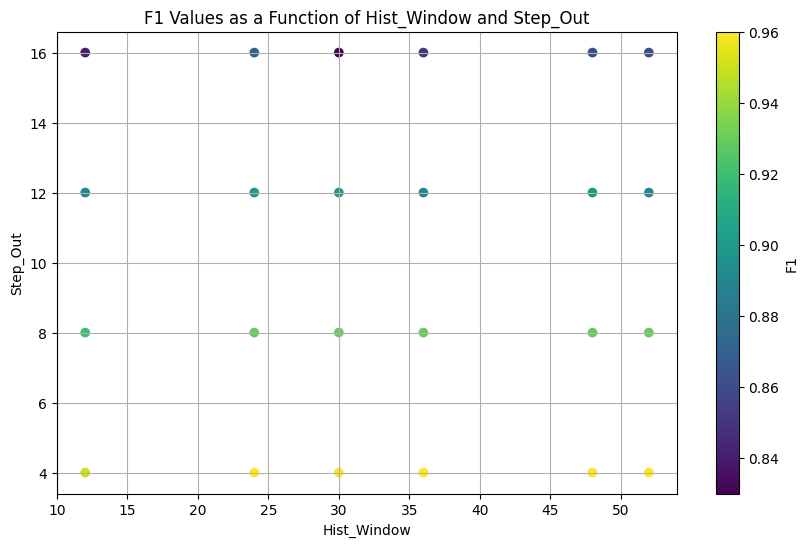

In [7]:

# Group data by hist_window and step_out combinations
grouped_data = {}
for params in parameter_result_list:
    hist_window, step_out, _, _, _, _, f1, _, _ = params
    key = (hist_window, step_out)
    if key not in grouped_data:
        grouped_data[key] = []
    grouped_data[key].append((f1, params))

# Find the combination with the largest f1 value for each hist_window, step_out pair
max_f1_combinations = {}
for key, data_list in grouped_data.items():
    max_f1_combinations[key] = max(data_list, key=lambda x: x[0])[1]

# Plot f1 values as a function of hist_window and step_out
hist_windows = []
step_outs = []
f1s = []

for params in max_f1_combinations.values():
    hist_window, step_out, _, _, _, _, f1, _, _ = params
    hist_windows.append(hist_window)
    step_outs.append(step_out)
    f1s.append(f1)

plt.figure(figsize=(10, 6))
plt.scatter(hist_windows, step_outs, c=f1s, cmap='viridis', marker='o')
plt.colorbar(label='F1')
plt.xlabel('Hist_Window')
plt.ylabel('Step_Out')
plt.title('F1 Values as a Function of Hist_Window and Step_Out')
plt.grid(True)
plt.show()



In [8]:
# Combine hist_windows, step_outs, and f1s into a DataFrame
df = pd.DataFrame({'Hist_Window': hist_windows, 'Step_Out': step_outs, 'F1': f1s})

print(df)

    Hist_Window  Step_Out    F1
0          52.0       4.0  0.96
1          52.0       8.0  0.93
2          52.0      12.0  0.89
3          52.0      16.0  0.86
4          30.0       4.0  0.96
5          30.0       8.0  0.93
6          30.0      12.0  0.90
7          30.0      16.0  0.83
8          24.0       4.0  0.96
9          24.0       8.0  0.93
10         24.0      12.0  0.90
11         24.0      16.0  0.87
12         12.0       4.0  0.95
13         12.0       8.0  0.92
14         12.0      12.0  0.89
15         12.0      16.0  0.84
16         36.0       4.0  0.96
17         36.0       8.0  0.93
18         36.0      12.0  0.89
19         36.0      16.0  0.85
20         48.0       4.0  0.96
21         48.0       8.0  0.93
22         48.0      12.0  0.90
23         48.0      16.0  0.86


In [9]:
# Define a function to handle ties
def handle_ties(group):
    max_f1 = group['F1'].max()
    return group[group['F1'] == max_f1]

# Group the DataFrame by Step_Out and find the row(s) with the maximum F1 for each group
max_f1_rows = df.groupby('Step_Out', group_keys=False).apply(handle_ties)

# Sort by Step_Out
max_f1_rows_sorted = max_f1_rows.sort_values(by='Step_Out')

print(max_f1_rows_sorted)





    Hist_Window  Step_Out    F1
0          52.0       4.0  0.96
4          30.0       4.0  0.96
8          24.0       4.0  0.96
16         36.0       4.0  0.96
20         48.0       4.0  0.96
1          52.0       8.0  0.93
5          30.0       8.0  0.93
9          24.0       8.0  0.93
17         36.0       8.0  0.93
21         48.0       8.0  0.93
6          30.0      12.0  0.90
10         24.0      12.0  0.90
22         48.0      12.0  0.90
11         24.0      16.0  0.87


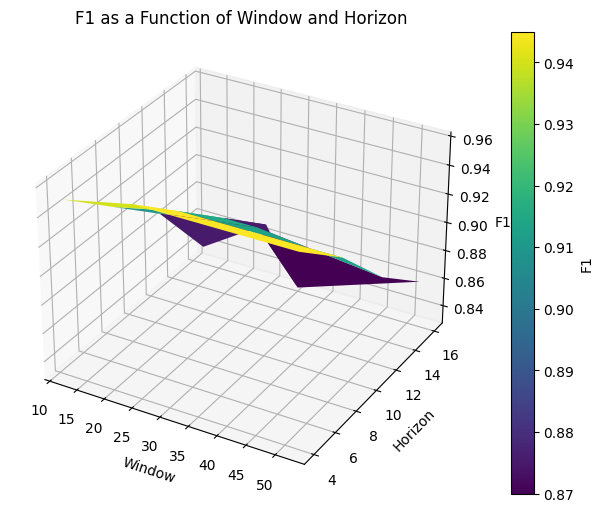

In [ ]:
# Create a meshgrid of hist_window and step_out
hist_windows_unique = df['Hist_Window'].unique()
step_outs_unique = df['Step_Out'].unique()
hist_windows_mesh, step_outs_mesh = np.meshgrid(hist_windows_unique, step_outs_unique)

# Create a 2D array of MSE values corresponding to the meshgrid
f1_mesh = np.zeros_like(hist_windows_mesh, dtype=float)
for i, hist_window in enumerate(hist_windows_unique):
    for j, step_out in enumerate(step_outs_unique):
        f1_mesh[j, i] = df[(df['Hist_Window'] == hist_window) & (df['Step_Out'] == step_out)]['F1'].iloc[0]

# Create the 3D surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(hist_windows_mesh, step_outs_mesh, f1_mesh, cmap='viridis', edgecolor='none')
ax.set_xlabel('Window')
ax.set_ylabel('Horizon')
ax.set_zlabel('F1')
ax.set_title('F1 as a Function of Window and Horizon')
fig.colorbar(surf, ax=ax, label='F1')
plt.show()
